In [1]:
import pandas as pd
import numpy as np

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

![Architecture](../assets/gate_of_lstm.webp)

In [3]:
# Intialize value of C_{t-1}, h_{t-1}, and x_{t}
x_t = 1.0
c_prev = 0.0
h_prev = 0.0

# Define weights and biases (all scalar)
w_f, u_f, b_f = 0.5, 0.1, 0.0
w_i, u_i, b_i = 0.4, 0.1, 0.0
w_c, u_c, b_c = 0.3, 0.1, 0.0
w_o, u_o, b_o = 0.6, 0.1, 0.0

# Gate calculations
f_t = sigmoid(w_f * x_t + u_f * h_prev + b_f)
i_t = sigmoid(w_i * x_t + u_i * h_prev + b_i)
g_t = tanh(w_c * x_t + u_c * h_prev + b_c)
c_t = f_t * c_prev + i_t * g_t
o_t = sigmoid(w_o * x_t + u_o * h_prev + b_o)
h_t = tanh(c_t) * o_t

# Print intermediate results
print("f_t (forget gate):", round(f_t, 4))
print("i_t (input gate):", round(i_t, 4))
print("g_t (cell candidate):", round(g_t, 4))
print("c_t (cell state):", round(c_t, 4))
print("o_t (output gate):", round(o_t, 4))
print("h_t (hidden state):", round(h_t, 4))

f_t (forget gate): 0.6225
i_t (input gate): 0.5987
g_t (cell candidate): 0.2913
c_t (cell state): 0.1744
o_t (output gate): 0.6457
h_t (hidden state): 0.1115


In [4]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from A11M.rnn.lstm import LSTM
from A11M.scale.standard import StandardScaler

lstm = LSTM(input_size=1, hidden_size=2, output_size=1)

inputs = [np.array([[1.0]]), np.array([[0.5]]), np.array([[0.2]])]

# Forward pass
outputs = lstm.forward(inputs)

# Print hidden states
for i, h in enumerate(outputs):
    print(f"Time step {i}: {h}")

Time step 0: [[-0.01391547 -0.02415795]]
Time step 1: [[-0.01171572 -0.0245462 ]]
Time step 2: [[-0.00654368 -0.01762934]]


In [5]:
model = LSTM(input_size=1, hidden_size=4, output_size=1)

# Example sequence (predict alternation)
X = [np.array([[0.0]]), np.array([[1.0]]), np.array([[0.0]]), np.array([[1.0]])] * 100
Y = [np.array([[1.0]]), np.array([[0.0]]), np.array([[1.0]]), np.array([[0.0]])] * 100

for epoch in range(1000):
    loss = model.train_step(X[:10], Y[:10], lr=0.01)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")

Epoch 0, Loss: 0.000112
Epoch 100, Loss: 0.000092
Epoch 200, Loss: 0.000075
Epoch 300, Loss: 0.000061
Epoch 400, Loss: 0.000050
Epoch 500, Loss: 0.000041
Epoch 600, Loss: 0.000033
Epoch 700, Loss: 0.000027
Epoch 800, Loss: 0.000022
Epoch 900, Loss: 0.000018


In [6]:
import kagglehub


path = kagglehub.dataset_download("umerhaddii/big-tech-giants-stock-price-data")

In [7]:
os.listdir(path)

['big_tech_companies.csv', 'big_tech_stock_prices.csv']

In [8]:
# read data big_tech_companies.csv
df_companies = pd.read_csv(os.path.join(path, 'big_tech_companies.csv'))
df_stock_prices = pd.read_csv(os.path.join(path, 'big_tech_stock_prices.csv'))

In [9]:
df_companies.head(n=5)

,stock_symbol,company
0,AAPL,Apple Inc.
1,ADBE,Adobe Inc.
2,AMZN,"Amazon.com, Inc."
3,CRM,"Salesforce, Inc."
4,CSCO,"Cisco Systems, Inc."


In [10]:
df_stock_prices.head()

,stock_symbol,date,open,high,low,close,adj_close,volume
0,AAPL,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,AAPL,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,AAPL,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,AAPL,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,AAPL,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


In [16]:
# Step 1: Filter AAPL and sort by date
df = df_stock_prices[df_stock_prices['stock_symbol'] == 'AAPL'].copy()
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Step 2: Extract 'close' prices
aapl_prices = df['close'].values.reshape(-1, 1)  # shape (N, 1)

# Step 3: Scale the prices using StandardScaler
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(aapl_prices).flatten()  # flatten for sequence generation

# Step 4: Create sequences
def create_lstm_sequences(data: np.ndarray, window_size=5):
    X, Y = [], []
    for i in range(len(data) - window_size):
        x_seq = [np.array([[data[j]]]) for j in range(i, i + window_size)]
        y_target = np.array([[data[i + window_size]]])
        X.append(x_seq)
        Y.append(y_target)
    return X, Y

X, Y = create_lstm_sequences(scaled_prices, window_size=20)

# Optional: Use subset for faster training
X_train, Y_train = X[:500], Y[:500]

# Step 5: Initialize model
model = LSTM(input_size=1, hidden_size=10, output_size=1)


In [ ]:
print(len(X), len(Y))

In [ ]:
for epoch in range(1000):
    total_loss = 0
    for x_seq, y_target in zip(X_train, Y_train):
        loss = model.train_step(x_seq, [y_target], lr=0.01)
        total_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(X_train):.6f}")

Epoch 0, Loss: 0.282767
Epoch 100, Loss: 0.001002
Epoch 200, Loss: 0.000999
Epoch 300, Loss: 0.000995
Epoch 400, Loss: 0.000992


In [13]:
# Use the last sequence for prediction
last_seq = X[-1]  # shape: list of 5 arrays, each (1,1)
pred = model.predict(last_seq)[-1]  # shape (1,1)

# Inverse transform to get actual price
predicted_price = scaler.inverse_transform(pred)
print(f"Predicted close price: {predicted_price.item():.2f}")

Predicted close price: 15.77


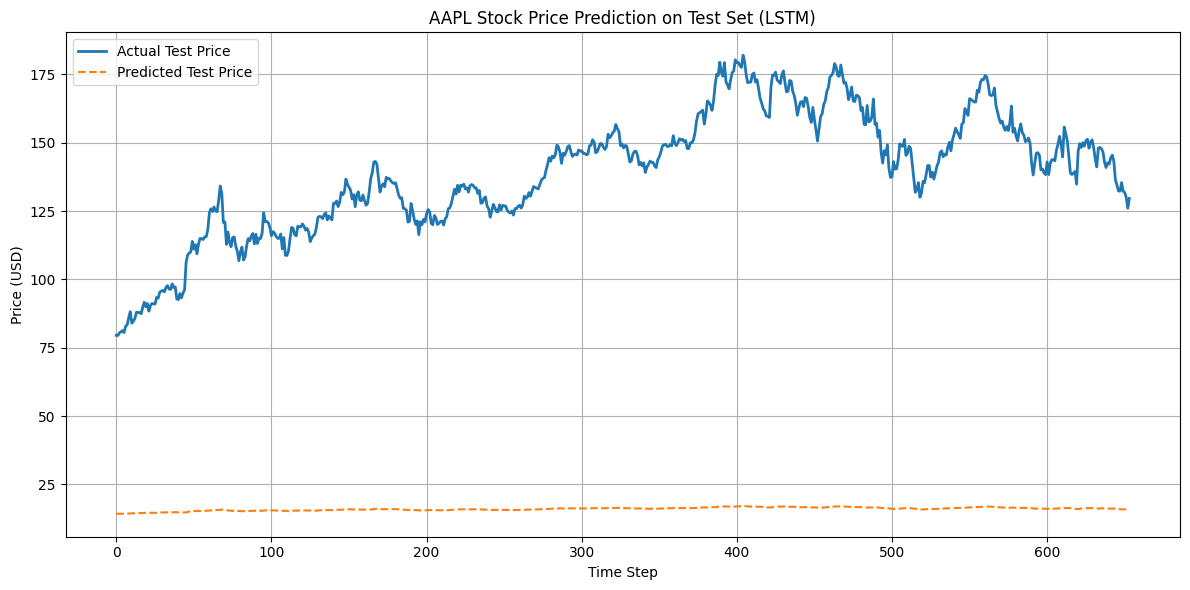

In [15]:
from matplotlib import pyplot as plt


window_size = 5
X_all, Y_all = create_lstm_sequences(scaled_prices, window_size=window_size)

# === 2. Train/Test split ===
split_index = int(len(X_all) * 0.8)
X_train, Y_train = X_all[:split_index], Y_all[:split_index]
X_test, Y_test = X_all[split_index:], Y_all[split_index:]

# === 4. Predict on test set ===
predicted_scaled_test = []
for seq in X_test:
    y_pred = model.predict(seq)[-1]
    predicted_scaled_test.append(y_pred[0][0])

# === 5. Inverse transform ===
predicted_test_prices = scaler.inverse_transform(np.array(predicted_scaled_test))
actual_test_prices = scaler.inverse_transform(np.array([y[0][0] for y in Y_test]))

# === 6. Plot testing results ===
plt.figure(figsize=(12, 6))
plt.plot(actual_test_prices, label="Actual Test Price", linewidth=2)
plt.plot(predicted_test_prices, label="Predicted Test Price", linestyle='--')
plt.title("AAPL Stock Price Prediction on Test Set (LSTM)")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()